## 必要工作

In [84]:
import tensorflow as tf
from keras.metrics import AUC
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.metrics import Precision, Recall
from keras.losses import BinaryCrossentropy
import datetime
from model.nn import multichannel_network
from model.data import Dataset, DataGenerator
from sklearn.utils import class_weight
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

def plot_picture(history):
    '''
    画出训练集和验证集的损失和精度变化，分析模型状态
    :return:
    '''

    # 画出训练集和验证集的损失和精度变化，分析模型状态

    acc = history.history['auc_2']  # 训练集acc
    val_acc = history.history['val_auc_2']  # 验证集 acc
    loss = history.history['loss']  # 训练损失
    val_loss = history.history['val_loss']  # 验证损失
    epochs = range(1, len(acc) + 1)  # 迭代次数
    plt.plot(epochs, loss, 'bo', label='Training loss')  # bo for blue dot 蓝色点
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
 
    plt.clf()  # clar figure

    plt.plot(epochs, acc, 'bo', label='Training AUPRC')  # bo for blue dot 蓝色点
    plt.plot(epochs, val_acc, 'b', label='Validation AUPRC')
    plt.title('Training and validation AUPRC')
    plt.xlabel('Epochs')
    plt.ylabel('AUPRC')
    plt.legend()
    plt.show()
 
    plt.clf()

In [58]:
tf.random.set_seed(40)
# Dataset Setting: 
## choose from ['methylation', 'gene_expression', 'cnv', 'mutation']
FEATURE = ['gene_expression', 'methylation', 'mutation', 'cnv'] 
ds = Dataset(
    feature_contained=FEATURE, 
    dataset='CTRP', 
    set_label=True, 
    response='AUC', 
    threshold=.58)
# CTRP, "AUC", 0.58, 0.001
# GDSC, "AUC", .88, 0.001
# model parameters settings
ds.save()


Loading Copy Number Abberation Data...
Loading Copy Number Abberation Data Done
Loading Gene Expression Data...
Loading Gene Expression Data Done
Loading Methylation Data...


/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading Methylation Data Done
Loading Mutations Data...
Loading Mutations Data Done
Begin loading drug data...
After filtering, GDSC has tested 477 drugs; CTRP has tested 425 drugs
After combining, unique cid number is 792


  0%|          | 0/792 [00:00<?, ?it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/_lib/_util.py:69: RuntimeWarning: overflow encountered in _ncx2_cdf
  np.place(out, cond, f(*temp))
  0%|          | 1/792 [00:00<01:44,  7.59it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6630: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)
  0%|          | 2/792 [00:00<01:57,  6.71it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
100%|██████████| 792/792 [01:28<00:00,  8.90it/s]


Drug data loaded
Loading CTRP Experiment Data...
Loading Experiment Data Done
Begin Preprocessing Experiment!
Select Overlapping Cellines...
Index(['DRUG_NAME', 'SMILES', 'CELL_LINE_NAME', 'AUC', 'DATASET'], dtype='object')
Select Overlapping Cellines with available PubChem CIDs...
Create Unique Sample Barcode...
Exclude response value...
Experiment Done!
Preparing Omics data...
Omics data Done!
We have 38175 samples in dataset...
Save the dataset into hdf5 data format...
Done!


In [65]:
lr_rate = 0.01
dropout_rate = .5
batch_size = 64
epochs = 20

# Split train, test and validation set for training and testing, build generators
partition = ds.split(data=ds.sample_barcode, validation=True)
train = partition['train']
test = partition['test']
validation = partition['validation']


In [66]:
train_generator = DataGenerator(sample_barcode=train, **ds.get_config(), batch_size=batch_size)
validation_generator = DataGenerator(sample_barcode=validation, **ds.get_config(), batch_size=batch_size)
test_generator = DataGenerator(sample_barcode=test, **ds.get_config(), batch_size=batch_size)

# Training parameters
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique([ds.labels[x] for x in train]),
                                                 y=[ds.labels[x] for x in train])

weights_dict = {i:w for i,w in enumerate(class_weights)}
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch, lr):
    if(epoch % 5 ==0 and epoch !=0):
        return lr*0.1
    else:
        return lr
reduce_lr = LearningRateScheduler(scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)


In [68]:
# model building
model = multichannel_network(
    data=ds.omics_data, 
    drug_data=ds.drug_info,
    feature_contained=FEATURE, 
    train_sample_barcode=train) 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=
              [
                Precision(name="precision"),
                Recall(name="recall"),
                AUC(curve='ROC', name="AUC"),
                AUC(curve='PR', name="AUPRC")
              ]
            )

history = model.fit(
    x=train_generator, 
    epochs=epochs,
    validation_data=validation_generator, 
    callbacks=[reduce_lr],
    class_weight=weights_dict
                    )

scores = model.evaluate(x=test_generator) 
print(list(scores))


Epoch 1/20
477/477 [==============================] - 136s 278ms/step - loss: 1.0108 - precision: 0.5356 - recall: 0.7227 - AUC: 0.7863 - AUPRC: 0.6092 - val_loss: 0.7726 - val_precision: 0.5477 - val_recall: 0.7422 - val_AUC: 0.8220 - val_AUPRC: 0.6671 - lr: 0.0100
Epoch 2/20
477/477 [==============================] - 148s 309ms/step - loss: 0.7326 - precision: 0.5899 - recall: 0.7700 - AUC: 0.8365 - AUPRC: 0.6935 - val_loss: 0.6556 - val_precision: 0.6024 - val_recall: 0.8000 - val_AUC: 0.8648 - val_AUPRC: 0.7474 - lr: 0.0100
Epoch 3/20
477/477 [==============================] - 134s 280ms/step - loss: 0.6264 - precision: 0.6108 - recall: 0.7971 - AUC: 0.8644 - AUPRC: 0.7420 - val_loss: 0.6172 - val_precision: 0.5916 - val_recall: 0.8168 - val_AUC: 0.8724 - val_AUPRC: 0.7618 - lr: 0.0100
Epoch 4/20
477/477 [==============================] - 133s 279ms/step - loss: 0.5823 - precision: 0.6323 - recall: 0.8022 - AUC: 0.8729 - AUPRC: 0.7662 - val_loss: 0.5724 - val_precision: 0.6112 - va

Evaluation

In [6]:
all_generator = DataGenerator(sample_barcode=validation+test, **ds.get_config(), batch_size=batch_size)

In [7]:
model.evaluate(x=all_generator)

119/119 [==============================] - 26s 214ms/step - loss: 0.3784 - precision: 0.6959 - recall: 0.8602 - auc: 0.9281 - auc_1: 0.8666


[0.3783837854862213,
 0.6959125995635986,
 0.8601916432380676,
 0.9281399846076965,
 0.8666465878486633]

save_model

In [8]:
tf.saved_model.save(model, 'CTRP_0.01_5-0.1_64_20_all_normalized')

INFO:tensorflow:Assets written to: CTRP_0.01_5-0.1_64_20_all_normalized/assets


INFO:tensorflow:Assets written to: CTRP_0.01_5-0.1_64_20_all_normalized/assets


In [9]:
_model_ = tf.saved_model.load('CTRP_0.01_5-0.1_64_20_all_normalized')

define two useful functions

In [ ]:
def prepare(candidate):
    celline_candidate = [i.split('_')[0] for i in candidate]
    drug_candidate = [i.split('_')[1] for i in candidate]
    feature = {}
    feature['fingerprint'] = ds.drug_info.drug_feature['fingerprint'].loc[drug_candidate].values.astype(np.float32)
    feature['rdkit2d'] = ds.drug_info.drug_feature['rdkit2d'].loc[drug_candidate].values.astype(np.float32)

    for i in ds.feature_contained:
        feature[i] = ds.omics_data[i].loc[celline_candidate].values.astype(np.float32)
    return feature

In [ ]:
from tqdm import tqdm
import pandas as pd
def make_predict(model, candidate, ds, batch_size):
    """

    Args:
        candidate (list): list["CELLINE_DRUG"]
        ds (Dataset): Dataset Object
    """
    celline_candidate = [i.split('_')[0] for i in candidate]
    drug_candidate = [i.split('_')[1] for i in candidate]
    feature = {}
    for i in ds.feature_contained:
        feature[i] = ds.omics_data[i].loc[celline_candidate].values.astype(np.float32)
    
    feature['fingerprint'] = ds.drug_info.drug_feature['fingerprint'].loc[drug_candidate].values.astype(np.float32)
    feature['rdkit2d'] = ds.drug_info.drug_feature['rdkit2d'].loc[drug_candidate].values.astype(np.float32)
    chunks = []

    for i in range(0, len(candidate), batch_size):
        x = i
        sample = {i:feature[i][x:x+batch_size] for i in ds.feature_contained}
        sample.update(
            {
                "fingerprint": feature["fingerprint"][x:x+batch_size],
                "rdkit2d": feature['rdkit2d'][x:x+batch_size]
            }
        )
        chunks.append(sample)
    result = []

    for i in tqdm(chunks):
        result.append(model(i))
    result = np.concatenate(result, axis=-2)
    # result = result[0:len(candidate)]
    import pandas as pd
    df = pd.DataFrame(data=result, columns=['Sensitivity'])
    df['DRUG_NAME'] = drug_candidate
    df['CELL_LINE'] = celline_candidate
    return df 

# ANALYSIS

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## GDSC and CTRPv2 Basic Statistics

CTRP AUC Histogram

<AxesSubplot:xlabel='AUC', ylabel='Count'>

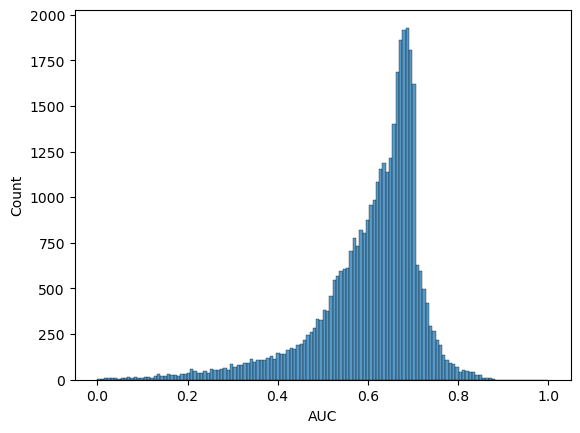

In [13]:
sns.histplot(data=ds.response['AUC'])

## AUC, AUPRC and Confusion Matrix over test dataset

In [14]:
pred_df = make_predict(model=_model_, candidate=test, ds=ds, batch_size=128)

100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


In [15]:
pred_df['true_labels'] = [ds.labels[i] for i in test]

In [16]:
pred_df.rename(columns={"AUC_predicted": "Sensitivity"}, inplace=True)

In [17]:
pred_df['pred_labels'] = [1 if i>0.5 else 0 for i in pred_df['Sensitivity']] # Define threshold

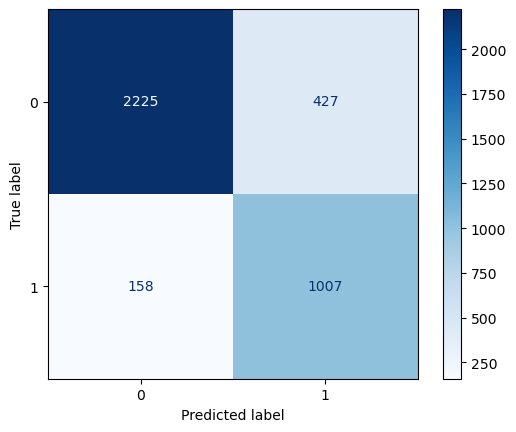

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['pred_labels']))
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)


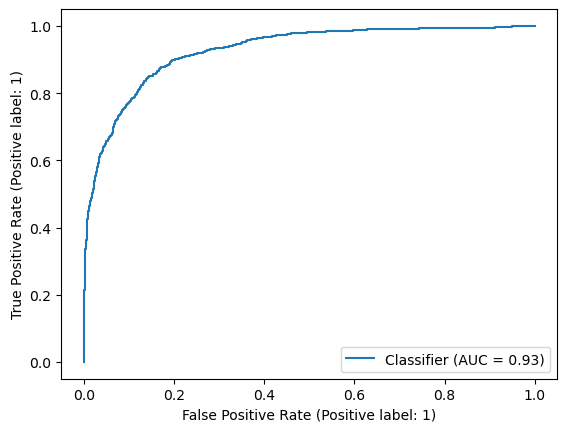

In [19]:
RocCurveDisplay.from_predictions(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['Sensitivity']),)

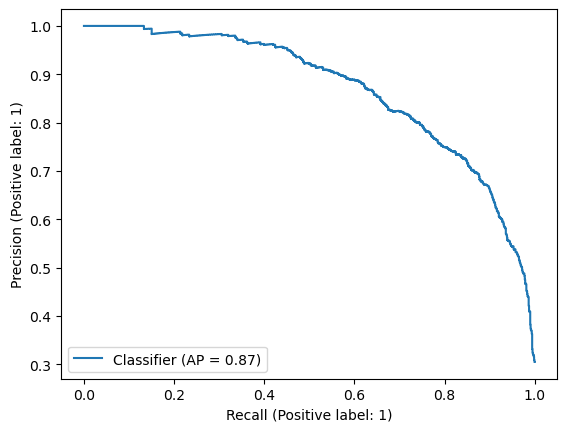

In [20]:
PrecisionRecallDisplay.from_predictions(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['Sensitivity']),)

## Predicted Scores Comparison between sensitive and insensitive drugs

<AxesSubplot:xlabel='true_labels', ylabel='Sensitivity'>

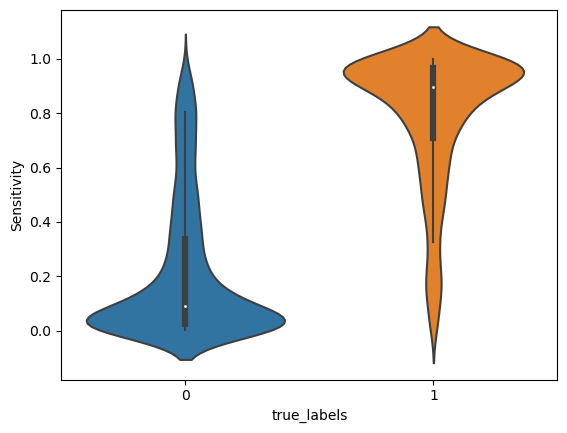

In [21]:
sns.violinplot(data=pred_df, x="true_labels", y="Sensitivity")

## Test Cancer(Lung, Colon, Breast, Stomach) Across drug types 

Find all cellines related to Colon Cancer

In [22]:
model_list = pd.read_csv('data/raw_data/model_list_20230307.csv')
lung_ccl = model_list[(model_list['tissue'] == 'Lung') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']
breast_ccl = model_list[(model_list['tissue'] == 'Breast') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']
colo_ccl = model_list[((model_list['tissue'] == 'Small Intestine') | (model_list['tissue'] == 'Large Intestine')) & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']
stomach_ccl = model_list[(model_list['tissue'] == 'Stomach') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']


In [23]:
celline_barcode = set(ds.celline_barcode)
colo_ccl = set(colo_ccl).intersection(celline_barcode)
lung_ccl = set(lung_ccl).intersection(celline_barcode)
breast_ccl = set(breast_ccl).intersection(celline_barcode)
stomach_ccl = set(stomach_ccl).intersection(celline_barcode)
drug_candidate = set(ds.drug_info.all_drugs.index).difference(set(ds.processed_experiment['DRUG_NAME']))

In [24]:
import itertools
l = {"colo": colo_ccl, "lung": lung_ccl, "breast": breast_ccl, "stomach": stomach_ccl}
experiment_candidate_dict = {name:itertools.product(i, drug_candidate) for name, i in l.items()}
for name, itm in experiment_candidate_dict.items():
    experiment_candidate_dict[name] = ["_".join(i) for i in itm]

In [25]:
for name, itm in experiment_candidate_dict.items():
    experiment_candidate_dict[name] = make_predict(model=_model_, candidate=itm, ds=ds, batch_size=64)

100%|██████████| 23/23 [00:04<00:00,  4.62it/s]


In [26]:
experiment_candidate_dict['breast']

,Sensitivity,DRUG_NAME,CELL_LINE
0,0.244107,MK-8776,HCC1395
1,0.259504,Bicalutamide,HCC1395
2,0.240383,SCH772984,HCC1395
3,0.238866,QL-X-138,HCC1395
4,0.678382,Telomerase Inhibitor IX,HCC1395
...,...,...,...
3999,0.898950,Entinostat,HCC1419
4000,0.008960,Cisplatin,HCC1419
4001,0.281602,Tipifarnib,HCC1419
4002,0.889174,Docetaxel,HCC1419


In [27]:
breast_drug_df = experiment_candidate_dict['breast'].groupby('DRUG_NAME').mean()
colo_drug_df = experiment_candidate_dict['colo'].groupby('DRUG_NAME').mean()
lung_drug_df = experiment_candidate_dict['lung'].groupby('DRUG_NAME').mean()
stomach_drug_df = experiment_candidate_dict['stomach'].groupby('DRUG_NAME').mean()

In [28]:
colo_set = set(colo_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
stomach_set = set(stomach_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
lung_set = set(lung_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
breast_set = set(breast_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)

In [29]:
common_set = colo_set.intersection(stomach_set, lung_set, breast_set)
print(common_set)

{'Belinostat', 'Crizotinib', 'Topotecan', 'Doxorubicin', 'Capivasertib', 'AZD5363', 'OF-1', 'Ipatasertib', 'AZD4877', 'Epirubicin', 'UMI-77', 'Palbociclib', 'Buparlisib', 'Paclitaxel', 'Vinorelbine', 'Bortezomib', 'PRT062607', 'Pictilisib', 'Panobinostat', 'Entinostat', 'Z-LLNle-CHO', 'Vinblastine', 'Flavopiridol', 'Foretinib', 'Docetaxel', 'Alectinib', 'Dinaciclib'}


In [30]:
print(f"Colon: {colo_set.difference(common_set)}")
print(f"Stomach: {stomach_set.difference(common_set)}")
print(f"Lung: {lung_set.difference(common_set)}")
print(f"Breast: {breast_set.difference(common_set)}")

Colon: {'AZ628', 'Gemcitabine', 'A-770041'}
Stomach: {'AZ628', 'Gemcitabine', 'Daporinad'}
Lung: {'Schweinfurthin A', 'A-770041', 'Daporinad'}
Breast: {'AZ628', 'Gemcitabine', 'Daporinad'}


## Test type-specific drugs Across Cancer Types

Gefitinib Lung Cancer-specific

In [31]:
gefitinib_entry = ["_".join((i, "gefitinib")) for i in ds.celline_barcode]

In [32]:
gefitinib_df = make_predict(model=model, candidate = gefitinib_entry, ds=ds, batch_size=64)

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


In [33]:
lung_ccl = model_list[(model_list['tissue'] == 'Lung') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']

In [34]:
gefitinib_df[gefitinib_df['CELL_LINE'].isin(lung_ccl)]

,Sensitivity,DRUG_NAME,CELL_LINE
14,0.628907,gefitinib,HARA
23,0.668916,gefitinib,SW1573
34,0.479745,gefitinib,EKVX
43,0.549425,gefitinib,SW1271
110,0.442002,gefitinib,A549


In [52]:
'SW1573_gefitinib' in test

False

## PRISM Holdout Validation

In [35]:
import pandas as pd
import numpy as np
from model.data import Dataset

In [36]:
prism = pd.read_csv('data/PRISM/secondary-screen-dose-response-curve-parameters.csv', low_memory=False)

In [37]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
prism['auc'] = minmax_scale(X=prism['auc'])
prism['auc'].quantile([0.3333, 0.66666, 0.9]) # threshold = 0.1728

0.33330    0.172789
0.66666    0.203854
0.90000    0.272822
Name: auc, dtype: float64

In [38]:
prism_drug = pd.DataFrame()
prism_drug['DRUG_NAME'] = prism['name']
prism_drug['CanonicalSMILES'] = prism['smiles']
prism_drug.drop_duplicates(subset='DRUG_NAME', keep='first', inplace=True)
prism_drug.reset_index(inplace=True, drop=True)
prism_drug_overlapped = list(set(prism_drug['DRUG_NAME']).intersection(set(ds.drug_info.all_drugs.index)))

In [39]:
prism['ccle_name'] = [str(i).split("_")[0] for i in prism['ccle_name']]

In [40]:
prism_experiment = prism[(prism['ccle_name'].isin(ds.celline_barcode))&(prism['name'].isin(prism_drug_overlapped))].reset_index(drop=True)

In [41]:
experiment_id = ["_".join((str(i), j)) for i,j in zip(prism_experiment['ccle_name'], prism_experiment['name'])]

In [42]:
experiment_df = pd.DataFrame()
experiment_df['SAMPLE_BARCODE'] = experiment_id
experiment_df['AUC'] = prism_experiment['auc']
experiment_df['LABELS'] = [1 if i<0.17 else 0 for i in prism_experiment['auc'] ]


In [43]:
experiment_candidate_prism = list(set(experiment_df['SAMPLE_BARCODE']).difference(train))

In [44]:
len(experiment_candidate_prism)

4422

In [45]:
pred_df = make_predict(model=_model_, candidate=experiment_candidate_prism, ds=ds, batch_size=64)

100%|██████████| 70/70 [00:14<00:00,  4.80it/s]


In [46]:
ref = experiment_df[experiment_df['SAMPLE_BARCODE'].isin(experiment_candidate_prism)].drop_duplicates(subset='SAMPLE_BARCODE')
pred_df["SAMPLE_BARCODE"] = ["_".join((i,j)) for i,j in zip(pred_df['CELL_LINE'], pred_df['DRUG_NAME'])]
pred_df = pred_df.join(ref.set_index('SAMPLE_BARCODE'), on='SAMPLE_BARCODE')

In [47]:
pred_df['LABELS_PRED'] = [1 if i>=0.5 else 0 for i in pred_df['Sensitivity']]

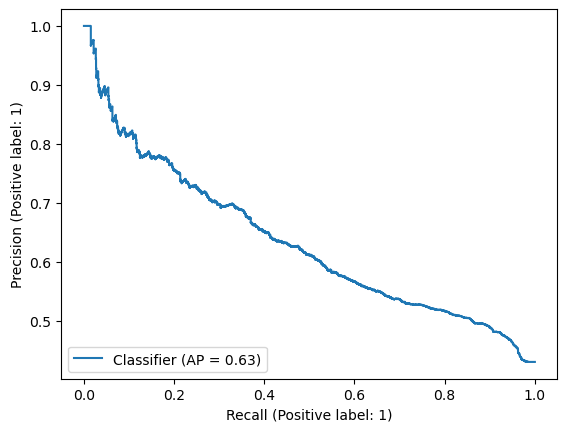

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

PrecisionRecallDisplay.from_predictions(y_true=list(pred_df['LABELS']), y_pred=list(pred_df['Sensitivity']))

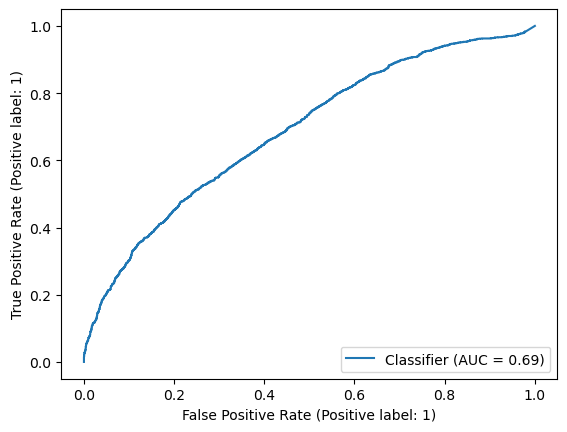

In [49]:
RocCurveDisplay.from_predictions(y_true=list(pred_df['LABELS']), y_pred=list(pred_df['Sensitivity']))

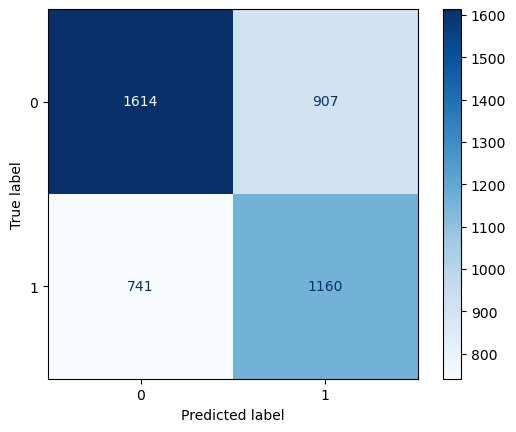

In [50]:
cm = confusion_matrix(y_true=list(pred_df['LABELS']), y_pred=list(pred_df['LABELS_PRED']))
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)


## SVM and GBDT

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from model.data import Dataset
from model.nn import CalculateSimilarity

In [71]:
temp_ds = Dataset(dataset='CTRP', feature_contained=['cnv'])

Loading Copy Number Abberation Data...
Loading Copy Number Abberation Data Done
Begin loading drug data...
After filtering, GDSC has tested 477 drugs; CTRP has tested 425 drugs
After combining, unique cid number is 792


  0%|          | 0/792 [00:00<?, ?it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/_lib/_util.py:69: RuntimeWarning: overflow encountered in _ncx2_cdf
  np.place(out, cond, f(*temp))
  0%|          | 1/792 [00:00<03:37,  3.64it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6630: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)
  0%|          | 2/792 [00:00<03:36,  3.65it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
100%|██████████| 792/792 [01:16<00:00, 10.29it/s]


Drug data loaded
Loading CTRP Experiment Data...
Loading Experiment Data Done
Begin Preprocessing Experiment!
Select Overlapping Cellines...
Index(['DRUG_NAME', 'SMILES', 'CELL_LINE_NAME', 'AUC', 'DATASET'], dtype='object')
Select Overlapping Cellines with available PubChem CIDs...
Create Unique Sample Barcode...
Exclude response value...
Experiment Done!
Preparing Omics data...
Omics data Done!
We have 40302 samples in dataset...


In [72]:
paritition = temp_ds.split(data=ds.sample_barcode, validation=True)
feature = prepare(candidate=paritition['train'])

In [29]:
test_feature = prepare(candidate=paritition['test'])

In [15]:
from functools import reduce
import numpy as np
feature = reduce(lambda x,y: np.append(x,y,axis=1), feature.values())
test_feature = reduce(lambda x,y: np.append(x,y,axis=1), test_feature.values())

In [25]:
labels = np.array([[ds.labels[i]] for i in paritition['train']]).ravel()
test_y = np.array([[ds.labels[i]] for i in paritition['test']]).ravel()

In [28]:
clf = RandomForestClassifier()
clf.fit(feature, labels)

RandomForestClassifier()

In [34]:
pred_y = clf.predict(X = test_feature)

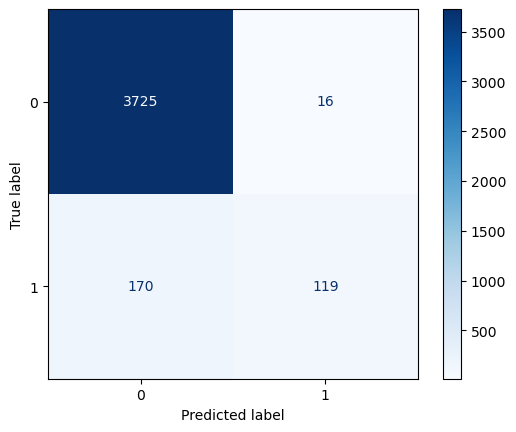

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=test_y, y_pred=pred_y)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)

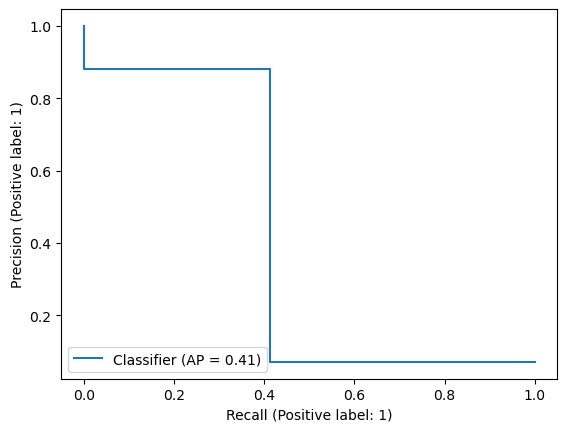

In [39]:
PrecisionRecallDisplay.from_predictions(y_true=test_y, y_pred=pred_y,)

## Consensus Clustering

In [70]:
ds.omics_data['cnv'].to_csv("data/data_visual/cnv.csv")
ds.omics_data['gene_expression'].to_csv('data/data_visual/gene_expression.csv')
ds.omics_data['methylation'].to_csv('data/data_visual/methylation.csv')
ds.omics_data['mutation'].to_csv('data/data_visual/mutation.csv')

CCL Feature

In [72]:
model.encoded_feature.clear()
temp = []
for i in range(len(ds.omics_data['cnv'])):
    temp.append({
        'fingerprint': np.zeros(shape=(1,881)),
        'rdkit2d': np.zeros(shape=(1,200,)),
        'cnv': ds.omics_data['cnv'].iloc[i].values,
        'gene_expression': ds.omics_data['gene_expression'].iloc[i].values,
        'mutation': ds.omics_data['mutation'].iloc[i].values,
        'methylation': ds.omics_data['methylation'].iloc[i].values, 
    })
for i in temp:
    model.__call__(inputs = i, training=False)
ccl_feature = model.encoded_feature
    

Drug Feature

In [220]:
model.encoded_feature.clear()
temp = []
for i in range(len(ds.drug_info.drug_feature['fingerprint'])):
    temp.append({
        'fingerprint': ds.drug_info.drug_feature['fingerprint'].iloc[i].values,
        'rdkit2d': ds.drug_info.drug_feature['rdkit2d'].iloc[i].values,
        'cnv': np.zeros(shape=(1,ds.omics_data['cnv'].shape[1])),
        'gene_expression': np.zeros(shape=(1,ds.omics_data['gene_expression'].shape[1])),
        'mutation': np.zeros(shape=(1,ds.omics_data['mutation'].shape[1])),
        'methylation': np.zeros(shape=(1,ds.omics_data['methylation'].shape[1])), 
    })
for i in temp:
    model.__call__(inputs = i, training=False)
drug_feature = model.encoded_feature

In [76]:
ccl_list = list(ds.omics_data['cnv'])

ccl

In [79]:
ccl_encoded_feature = np.stack([ccl_feature[i][0][256:] for i in range(len(ds.omics_data['cnv']))])

drug

In [225]:
drug_encoded_feature = np.stack([drug_feature[i][0][:256] for i in range(len(ds.drug_info.drug_feature['fingerprint']))])

Drug and CCL encoded feature after exclusion of outliers

In [233]:
import pandas as pd
import numpy as np
from scipy import stats
# Exclude Outliers
drug_encoded_df = pd.DataFrame(data=drug_encoded_feature, index=ds.drug_info.drug_feature['fingerprint'].index)
drug_encoded_df = drug_encoded_df[(np.abs(stats.zscore(drug_encoded_df)) < 3).all(axis=1)]

In [82]:
ccl_encoded_df = pd.DataFrame(data=ccl_encoded_feature, index=ds.omics_data['cnv'].index)
ccl_encoded_df = ccl_encoded_df[(np.abs(stats.zscore(ccl_encoded_df)) < 3).all(axis=1)]

In [238]:
ccl_encoded_df.T.to_csv("ccl_encoded.csv", index=None)
drug_encoded_df.T.to_csv("drug_encoded.csv", index=None)

Enrichment after `R` `ConsensusClusterPlus`

In [313]:
encoded_clrs = pd.read_csv('./encoded_clrs.csv').T.rename(columns={0:"Cluster"})
drug_clrs = pd.read_csv('./drug_clrs.csv').T.rename(columns={0:"Cluster"}) 

In [314]:
df = ds.processed_experiment[['DRUG_NAME', 'CELL_LINE_NAME', 'AUC']]

In [315]:
encoded_clrs = pd.concat([encoded_clrs[encoded_clrs['Cluster'] == i] for i in [1,2,3,4]])
drug_clrs = pd.concat([drug_clrs[drug_clrs['Cluster'] == i] for i in [1,2,3,4,5]]) 

In [316]:
drug_clrs = drug_clrs.loc[set(df['DRUG_NAME']).intersection(drug_clrs.index)]
drug_clrs = pd.concat([drug_clrs[drug_clrs['Cluster'] == i] for i in [1,2,3,4,5]]) 

/var/folders/wc/rh6kv76j5dxdxqbbrkkc3bn80000gn/T/ipykernel_59642/1834779828.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  drug_clrs = drug_clrs.loc[set(df['DRUG_NAME']).intersection(drug_clrs.index)]


In [317]:
df = pd.pivot_table(data=df, values=['AUC'], index=['DRUG_NAME'], columns=['CELL_LINE_NAME'])
df.fillna(1, inplace=True)
df = df['AUC']
df = df.loc[drug_clrs.index]
df = df[list(encoded_clrs.index)]

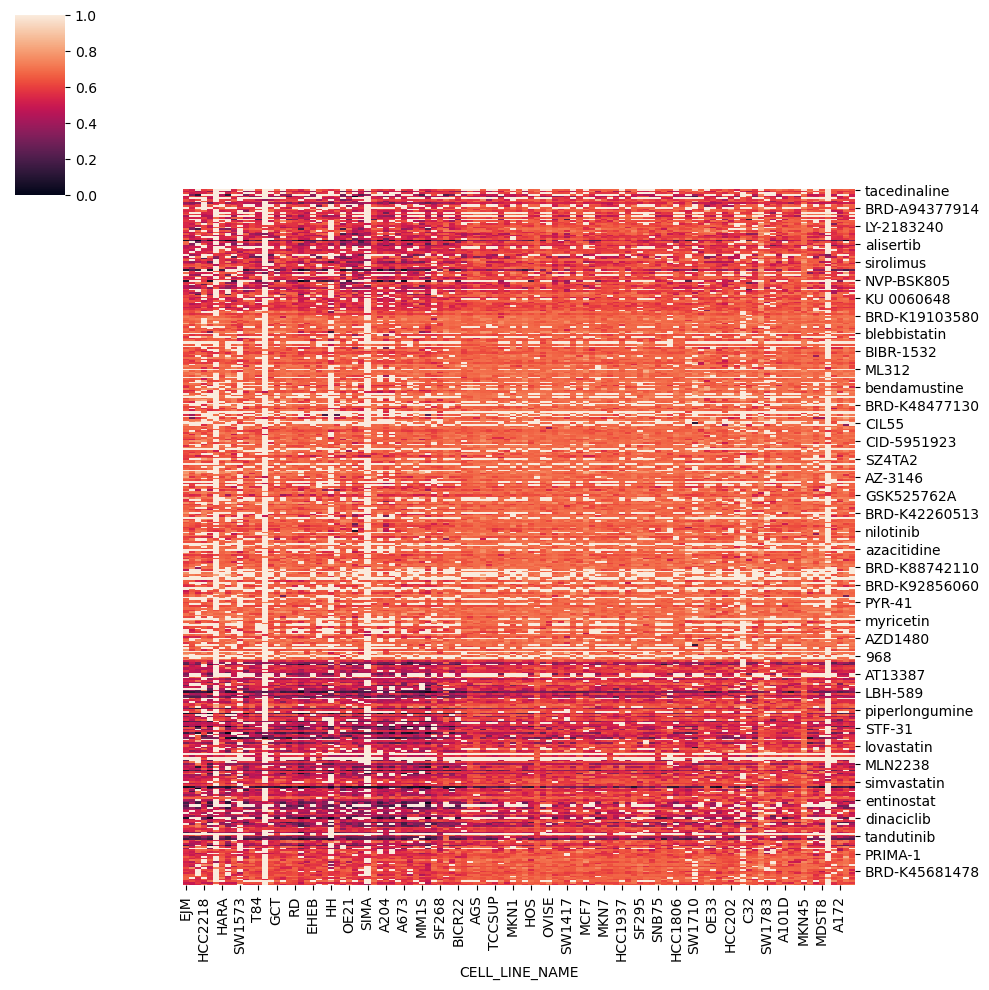

In [318]:
sns.clustermap(df, col_cluster=False, row_cluster=False)